# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, count, desc, explode, lit, min, max, split, stddev, udf
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import RegexTokenizer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.clustering import KMeans
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline



In [172]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import re

In [3]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
df = spark.read.json("mini_sparkify_event_data.json")

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
# Number of rows in this dataset
previous_count = df.count()
previous_count

286500

In [7]:
df.take(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

In [8]:
# Table form of dataset
df.select(df.columns).toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


### Investigate Authorization

In [9]:
# Types of authorization
df.select('auth').dropDuplicates().show()

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+



In [10]:
# let's find Cancelled user's activity

df.filter(df.auth=='Cancelled').select(['userId', 'level', 'sessionId', 'page', 'gender']).dropDuplicates().show()

+------+-----+---------+--------------------+------+
|userId|level|sessionId|                page|gender|
+------+-----+---------+--------------------+------+
|100011| free|       40|Cancellation Conf...|     M|
|     3| paid|     1324|Cancellation Conf...|     M|
|    18| paid|      514|Cancellation Conf...|     M|
|100019| free|       71|Cancellation Conf...|     M|
|200020| free|      351|Cancellation Conf...|     M|
|   125| free|      174|Cancellation Conf...|     M|
|    53| paid|     2003|Cancellation Conf...|     M|
|200024| paid|      208|Cancellation Conf...|     M|
|   106| paid|     1383|Cancellation Conf...|     F|
|    54| paid|     1819|Cancellation Conf...|     F|
|   103| paid|     1583|Cancellation Conf...|     F|
|100012| free|      156|Cancellation Conf...|     M|
|100023| paid|      109|Cancellation Conf...|     M|
|    51| paid|      934|Cancellation Conf...|     M|
|    70| paid|     1940|Cancellation Conf...|     M|
|100015| paid|      188|Cancellation Conf...| 

In [11]:
# let's find Guest user's activity

df.filter(df.auth=='Guest').select(['userId', 'level', 'sessionId', 'page', 'gender', 'song']).dropDuplicates().show()

+------+-----+---------+-------------------+------+----+
|userId|level|sessionId|               page|gender|song|
+------+-----+---------+-------------------+------+----+
|      | free|     1719|           Register|  null|null|
|      | free|      152|               Home|  null|null|
|      | free|     2288|               Help|  null|null|
|      | free|     2288|Submit Registration|  null|null|
|      | free|      155|              About|  null|null|
|      | free|     1402|           Register|  null|null|
|      | free|     1506|Submit Registration|  null|null|
|      | free|      151|              Error|  null|null|
|      | free|      151|               Home|  null|null|
|      | free|      155|               Help|  null|null|
|      | free|      153|              About|  null|null|
|      | free|     1506|           Register|  null|null|
|      | free|      154|           Register|  null|null|
|      | free|     1717|               Help|  null|null|
|      | free|      151|       

**To stop customer churning, we need UserID information, because with that we can find our target customer and offer them a deal before they leave the Sparkify platform. Therefore, Let's remove all rows with NULL or Empty UserID**

In [12]:
df = df.dropna(how = "any", subset = ["userId", "sessionId"])
current_count = df.count()
print("Deleted: {} \nCurrent Count: {}".format(previous_count-current_count, current_count))

Deleted: 0 
Current Count: 286500


In [13]:
df = df.filter(df.userId!="")
current_count = df.count()
print("Deleted: {} \nCurrent Count: {}".format(previous_count-current_count, current_count))

Deleted: 8346 
Current Count: 278154


### Investigate Pages

In [14]:
df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [15]:
df.filter(df.page=='Cancel').select(['userId', 'level', 'sessionId', 'gender']).dropDuplicates().show()

+------+-----+---------+------+
|userId|level|sessionId|gender|
+------+-----+---------+------+
|200016| free|      347|     F|
|    87| paid|     1092|     M|
|   125| free|      174|     M|
|   106| paid|     1383|     F|
|   122| paid|     1029|     F|
|100024| free|       42|     M|
|    17| paid|      797|     F|
|     3| paid|     1324|     M|
|200011| free|      267|     M|
|    28| paid|     1519|     F|
|100022| free|      191|     F|
|200001| free|      136|     M|
|   105| paid|      508|     M|
|200018| free|      268|     M|
|100006| free|        6|     F|
|100025| free|      129|     F|
|100023| paid|      109|     M|
|    18| paid|      514|     M|
|   143| free|      843|     F|
|200015| free|      270|     M|
+------+-----+---------+------+
only showing top 20 rows



In [16]:
df.filter(df.page=='Submit Downgrade').select(['userId', 'level', 'sessionId', 'gender']).dropDuplicates().show()

+------+-----+---------+------+
|userId|level|sessionId|gender|
+------+-----+---------+------+
|100025| paid|      123|     F|
|200025| paid|      115|     M|
|   141| paid|      479|     F|
|100015| paid|      121|     F|
|    59| paid|      510|     M|
|100004| paid|      147|     F|
|    81| paid|      725|     M|
|     9| paid|     1276|     M|
|    20| paid|      378|     F|
|    39| paid|     1546|     F|
|200020| paid|      222|     M|
|    85| paid|      734|     M|
|100012| paid|       94|     M|
|   109| paid|     1705|     F|
|   140| paid|     1918|     F|
|100009| paid|      126|     M|
|    35| paid|      812|     F|
|    35| paid|     1704|     F|
|100018| paid|       67|     M|
|    77| paid|      688|     F|
+------+-----+---------+------+
only showing top 20 rows



In [17]:
df.filter(df.page=='Cancellation Confirmation').select(['userId', 'level', 'sessionId', 'gender']).dropDuplicates().show()

+------+-----+---------+------+
|userId|level|sessionId|gender|
+------+-----+---------+------+
|200016| free|      347|     F|
|    87| paid|     1092|     M|
|   125| free|      174|     M|
|   106| paid|     1383|     F|
|   122| paid|     1029|     F|
|100024| free|       42|     M|
|    17| paid|      797|     F|
|     3| paid|     1324|     M|
|200011| free|      267|     M|
|    28| paid|     1519|     F|
|100022| free|      191|     F|
|200001| free|      136|     M|
|   105| paid|      508|     M|
|200018| free|      268|     M|
|100006| free|        6|     F|
|100025| free|      129|     F|
|100023| paid|      109|     M|
|    18| paid|      514|     M|
|   143| free|      843|     F|
|200015| free|      270|     M|
+------+-----+---------+------+
only showing top 20 rows



### Adding Extra column to show Hour of the day 

In [18]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn("hour", get_hour(df.ts))
df = df.withColumn("time", get_time(df.ts))

In [19]:
df.show(3)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+----+-------------------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|             song|status|           ts|           userAgent|userId|hour|               time|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+----+-------------------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|        Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|   0|2018-10-01 00:01:57|
|Five Iron Frenzy|Logged In|    Micah|     M|   

**Let's dig into UserID=87 activities.**

In [20]:
user87 = df.filter(df.userId==87)
print("No of events for user 87:", user87.count())

No of events for user 87: 1003


In [21]:
user87.filter(user87.page!='NextSong').select(['level','page', 'hour', 'time']).orderBy('ts', ascending=True).show(236)

+-----+--------------------+----+-------------------+
|level|                page|hour|               time|
+-----+--------------------+----+-------------------+
| free|                Home|   6|2018-10-01 06:47:15|
| free|         Roll Advert|   7|2018-10-01 07:18:44|
| free|             Upgrade|  15|2018-10-01 15:37:46|
| free|            Settings|  15|2018-10-01 15:41:30|
| free|           Thumbs Up|  15|2018-10-01 15:55:27|
| free|                Home|  16|2018-10-01 16:54:36|
| free|         Roll Advert|  16|2018-10-01 16:59:41|
| free|         Roll Advert|  17|2018-10-01 17:06:35|
| free|         Roll Advert|  17|2018-10-01 17:47:10|
| free|                Home|   6|2018-10-02 06:15:54|
| free|           Thumbs Up|   6|2018-10-02 06:40:52|
| free|     Add to Playlist|   6|2018-10-02 06:41:16|
| free|         Roll Advert|   7|2018-10-02 07:00:42|
| free|         Roll Advert|   7|2018-10-02 07:05:13|
| free|           Thumbs Up|   7|2018-10-02 07:11:23|
| free|                Home|

**Based on above user activity we can see that he upgraded the service from Free Tier to Paid, but cancelled the paid service with-in 24 hour window. Before leaving the Sparkify platform, user has visited Downgrade page, but eventually cancelled his account.**

In [22]:
ChurnUser_list = [(row['userId']) for row in df.filter(df.page=="Cancellation Confirmation").select('userId').dropDuplicates().collect()]
ChurnUser_list
ChurnUser_list = [(row['userId']) for row in df.filter(df.page=="Cancellation Confirmation").select('userId').dropDuplicates().collect()]
ChurnUser_list


['125',
 '51',
 '54',
 '100014',
 '101',
 '29',
 '100021',
 '87',
 '73',
 '3',
 '28',
 '100022',
 '100025',
 '300007',
 '100006',
 '18',
 '70',
 '100005',
 '17',
 '100007',
 '300001',
 '100009',
 '100015',
 '200024',
 '100003',
 '103',
 '100024',
 '53',
 '122',
 '200017',
 '58',
 '100011',
 '100019',
 '100012',
 '200018',
 '200016',
 '200020',
 '106',
 '143',
 '32',
 '200001',
 '105',
 '200011',
 '100023',
 '100013',
 '100017',
 '121',
 '12',
 '200015',
 '129',
 '200021',
 '100001']

In [23]:
df = df.withColumn("Churn", df.userId.isin(ChurnUser_list))

In [24]:
df.filter(df.page=='Cancellation Confirmation').select(['level','page', 'hour', 'time', 'Churn']).show(50)


+-----+--------------------+----+-------------------+-----+
|level|                page|hour|               time|Churn|
+-----+--------------------+----+-------------------+-----+
| paid|Cancellation Conf...|  20|2018-10-07 20:26:30| true|
| paid|Cancellation Conf...|  21|2018-10-08 21:10:46| true|
| free|Cancellation Conf...|   4|2018-10-12 04:35:18| true|
| paid|Cancellation Conf...|  20|2018-10-12 20:17:21| true|
| paid|Cancellation Conf...|  21|2018-10-13 21:19:44| true|
| free|Cancellation Conf...|   7|2018-10-15 07:34:14| true|
| paid|Cancellation Conf...|  22|2018-10-16 22:30:37| true|
| paid|Cancellation Conf...|   0|2018-10-17 00:29:21| true|
| paid|Cancellation Conf...|   7|2018-10-17 07:02:29| true|
| paid|Cancellation Conf...|   7|2018-10-17 07:39:32| true|
| paid|Cancellation Conf...|  15|2018-10-20 15:49:16| true|
| paid|Cancellation Conf...|  19|2018-10-20 19:01:08| true|
| paid|Cancellation Conf...|   7|2018-10-22 07:29:34| true|
| paid|Cancellation Conf...|  15|2018-10

In [25]:
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId',
 'hour',
 'time',
 'Churn']

In [26]:
df.filter(df.page=="Submit Downgrade").select(['userId', 'hour', 'Churn', 'song', 'level']).show()

+------+----+-----+----+-----+
|userId|hour|Churn|song|level|
+------+----+-----+----+-----+
|   131|  11|false|null| paid|
|    38|  21|false|null| paid|
|   141|  14|false|null| paid|
|    30|  10|false|null| paid|
|    20|  11|false|null| paid|
|    12|   4| true|null| paid|
|    11|   6|false|null| paid|
|    61|   7|false|null| paid|
|    81|  13|false|null| paid|
|    85|   9|false|null| paid|
|   140|   9|false|null| paid|
|    35|  21|false|null| paid|
|    54|  12| true|null| paid|
|    77|  12|false|null| paid|
|    59|  19|false|null| paid|
|   103|  23| true|null| paid|
|    95|   7|false|null| paid|
|    74|  19|false|null| paid|
|    85|  12|false|null| paid|
|     9|   5|false|null| paid|
+------+----+-----+----+-----+
only showing top 20 rows



In [27]:
user_49 = df.filter(df.userId=='49')
user_49.count()

1091

In [28]:
user_49.filter(user_49.page!='NextSong').select(['page', 'level', 'Churn', 'hour', 'time', 'length']).show(219)

+----------------+-----+-----+----+-------------------+------+
|            page|level|Churn|hour|               time|length|
+----------------+-----+-----+----+-------------------+------+
|       Thumbs Up| paid|false|   2|2018-10-04 02:47:46|  null|
| Add to Playlist| paid|false|   2|2018-10-04 02:47:46|  null|
|     Thumbs Down| paid|false|   2|2018-10-04 02:51:20|  null|
|            Help| paid|false|   3|2018-10-04 03:31:26|  null|
|            Home| paid|false|   3|2018-10-04 03:31:33|  null|
|            Home| paid|false|   3|2018-10-04 03:54:06|  null|
|            Home| paid|false|   4|2018-10-04 04:27:31|  null|
|      Add Friend| paid|false|   4|2018-10-04 04:32:01|  null|
|      Add Friend| paid|false|   5|2018-10-04 05:08:10|  null|
| Add to Playlist| paid|false|   6|2018-10-04 06:15:48|  null|
| Add to Playlist| paid|false|   6|2018-10-04 06:36:21|  null|
|       Thumbs Up| paid|false|   6|2018-10-04 06:52:33|  null|
|       Thumbs Up| paid|false|   7|2018-10-04 07:34:44|

**To include other users in Churn process who downgraded from Paid to Free tier, we need to make sure that their current level is free. Just filtering based on "Submit Downgrade" event is not enough.**

**For Now, Let's focus on users who cancelled the account**

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [29]:
df_pandas = df.toPandas()

In [30]:
df_pandas.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,registration,sessionId,song,status,ts,userAgent,userId,hour,time,Churn
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,...,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0,2018-10-01 00:01:57,False
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0,2018-10-01 00:03:00,False
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,...,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0,2018-10-01 00:06:34,False
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0,2018-10-01 00:06:56,False
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,...,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0,2018-10-01 00:11:16,False


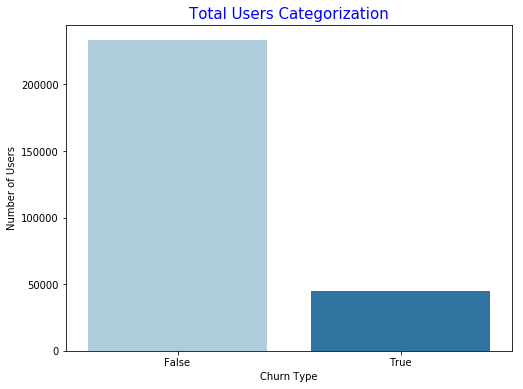

In [31]:
plt.figure(figsize=(8,6))
sns.countplot(df_pandas.Churn, palette='Paired')
plt.xlabel('Churn Type')
plt.ylabel('Number of Users')
plt.title('Total Users Categorization',color = 'blue',fontsize=15);

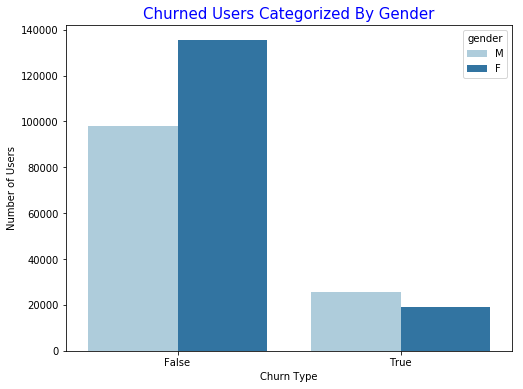

In [32]:
churnByGender= df_pandas[['Churn', 'gender', 'userId']].groupby(['Churn', 'gender']).count()
churnByGender.reset_index(inplace=True)
plt.figure(figsize=(8,6))
sns.barplot(x="Churn", y='userId', hue="gender", hue_order=['M','F'], data=churnByGender, palette='Paired')
#plt.xticks(rotation=45)
plt.xlabel('Churn Type')
plt.ylabel('Number of Users')
plt.title('Churned Users Categorized By Gender',color = 'blue',fontsize=15);

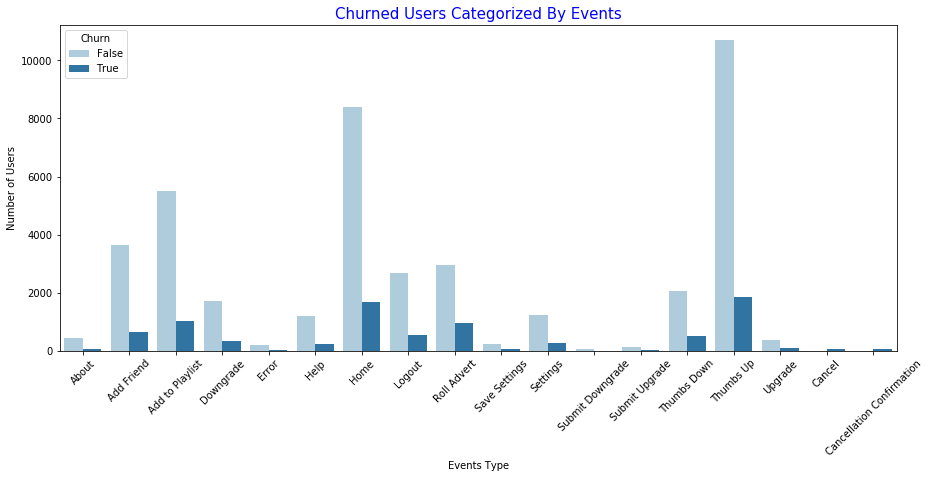

In [33]:
churnByEvents = df_pandas[df_pandas['page']!='NextSong'][['Churn', 'userId', 'page']].groupby(['Churn', 'page']).count()
churnByEvents.reset_index(inplace=True)
plt.figure(figsize=(15,6))
sns.barplot(x="page", y='userId', hue="Churn", data=churnByEvents, palette='Paired')
plt.xticks(rotation=45)
plt.xlabel('Events Type')
plt.ylabel('Number of Users')
plt.title('Churned Users Categorized By Events',color = 'blue',fontsize=15);


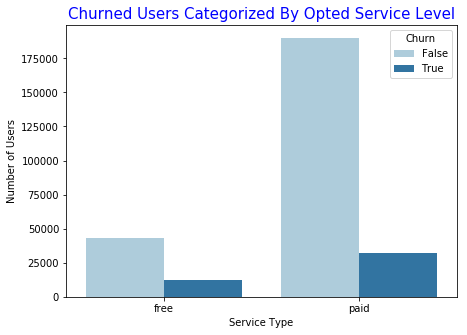

In [34]:
churnByLevel = df_pandas[['Churn', 'userId', 'level']].groupby(['Churn', 'level']).count()
churnByLevel.reset_index(inplace=True)
plt.figure(figsize=(7,5))
sns.barplot(x="level", y='userId', hue="Churn", data=churnByLevel, palette='Paired')
#plt.xticks(rotation=45)
plt.xlabel('Service Type')
plt.ylabel('Number of Users')
plt.title('Churned Users Categorized By Opted Service Level',color = 'blue',fontsize=15);


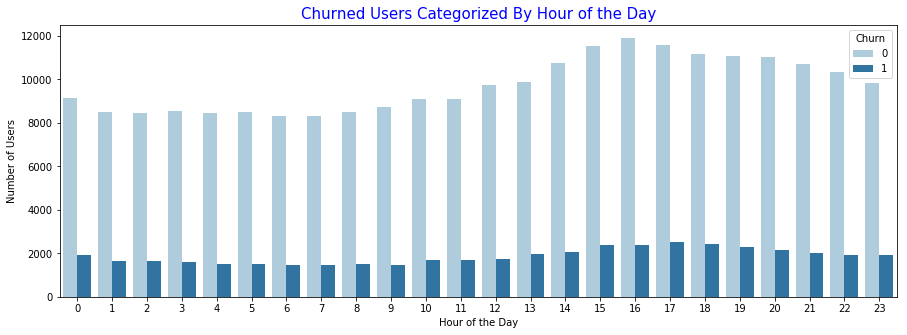

In [35]:
churnByHour = df_pandas[['Churn', 'userId', 'hour']].groupby(['Churn', 'hour']).count()
churnByHour.reset_index(inplace=True)
churnByHour=churnByHour.astype('int')
churnByHour.sort_values('hour', inplace=True)
plt.figure(figsize=(15,5))
sns.barplot(x="hour", y='userId', hue="Churn", data=churnByHour, palette='Paired')
#plt.xticks(rotation=45)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Users')
plt.title('Churned Users Categorized By Hour of the Day',color = 'blue',fontsize=15);


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [36]:
df_pandas.head(2)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,registration,sessionId,song,status,ts,userAgent,userId,hour,time,Churn
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,...,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0,2018-10-01 00:01:57,False
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0,2018-10-01 00:03:00,False


In [37]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- time: string (nullable = true)
 |-- Churn: boolean (nullable = true)



In [38]:
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId',
 'hour',
 'time',
 'Churn']

**After initial analysis, I am deciding to keep below column to start feature engineering and modelling.**

**['artist', 'gender', 'level', 'page', 'song','userId', 'Churn']**

In [39]:

df = df.select(['artist', 'gender', 'level', 'page', 'song','userId', 'Churn'])



In [40]:
df.columns

['artist', 'gender', 'level', 'page', 'song', 'userId', 'Churn']

In [41]:
df.describe().show()

+-------+------------------+------+------+-------+--------------------+-----------------+
|summary|            artist|gender| level|   page|                song|           userId|
+-------+------------------+------+------+-------+--------------------+-----------------+
|  count|            228108|278154|278154| 278154|              228108|           278154|
|   mean| 551.0852017937219|  null|  null|   null|            Infinity|59682.02278593872|
| stddev|1217.7693079161374|  null|  null|   null|                 NaN|109091.9499991047|
|    min|               !!!|     F|  free|  About|ÃÂg ÃÂtti Gr...|               10|
|    max| ÃÂlafur Arnalds|     M|  paid|Upgrade|ÃÂau hafa slopp...|               99|
+-------+------------------+------+------+-------+--------------------+-----------------+



In [42]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- level: string (nullable = true)
 |-- page: string (nullable = true)
 |-- song: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- Churn: boolean (nullable = true)



In [43]:
df = df.replace(['F','M'], ['1', '0'], 'gender')

In [44]:
df = df.withColumn("gender", df["gender"].cast(IntegerType()))


In [45]:
df = df.withColumn("Churn", df["Churn"].cast(IntegerType()))
df = df.withColumn("userId", df["userId"].cast(IntegerType()))
df = df.replace(['free','paid'], ['0', '1'], 'level')
df = df.withColumn("level", df["level"].cast(IntegerType()))

In [46]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- gender: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- page: string (nullable = true)
 |-- song: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- Churn: integer (nullable = true)



In [47]:
df.show(2)

+----------------+------+-----+--------+---------+------+-----+
|          artist|gender|level|    page|     song|userId|Churn|
+----------------+------+-----+--------+---------+------+-----+
|  Martha Tilston|     0|    1|NextSong|Rockpools|    30|    0|
|Five Iron Frenzy|     0|    0|NextSong|   Canada|     9|    0|
+----------------+------+-----+--------+---------+------+-----+
only showing top 2 rows



In [48]:
df.select('page').drop_duplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [49]:
df_sparkify = df.groupBy(["userId", "Churn", "gender", "level"]).count()
df_sparkify.show()

+------+-----+------+-----+-----+
|userId|Churn|gender|level|count|
+------+-----+------+-----+-----+
|200008|    0|     1|    1| 1988|
|    93|    0|     0|    0|  566|
|100013|    1|     1|    0|  303|
|    91|    0|     0|    1| 2862|
|     4|    0|     0|    0|  141|
|300021|    0|     1|    1| 4650|
|100019|    1|     0|    0|   89|
|100021|    1|     0|    0|  319|
|   140|    0|     1|    1| 5662|
|    73|    1|     1|    0|   16|
|    59|    0|     0|    1|  693|
|200025|    0|     0|    0|  597|
|    41|    0|     1|    1| 2220|
|    37|    0|     0|    0|   79|
|    54|    1|     1|    1| 2859|
|    69|    0|     1|    0|   39|
|200024|    1|     0|    0|  342|
|300005|    0|     1|    0|   64|
|    27|    0|     0|    0|  291|
|   101|    1|     0|    0|   76|
+------+-----+------+-----+-----+
only showing top 20 rows



In [50]:
Event_list = [(row['page']) for row in df.select('page').dropDuplicates().collect()]
#df = df.withColumn("Churn", df.userId.isin(ChurnUser_list))
for event in Event_list:
    df_temp = df.filter(df.page==event).groupBy(df.userId).count()
    df_temp = df_temp.withColumnRenamed('count', event)
    df_sparkify = df_sparkify.join(df_temp, 'userId', how='left')

#df_dummy.show()

In [51]:
df_sparkify.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- Churn: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- count: long (nullable = false)
 |-- Cancel: long (nullable = true)
 |-- Submit Downgrade: long (nullable = true)
 |-- Thumbs Down: long (nullable = true)
 |-- Home: long (nullable = true)
 |-- Downgrade: long (nullable = true)
 |-- Roll Advert: long (nullable = true)
 |-- Logout: long (nullable = true)
 |-- Save Settings: long (nullable = true)
 |-- Cancellation Confirmation: long (nullable = true)
 |-- About: long (nullable = true)
 |-- Settings: long (nullable = true)
 |-- Add to Playlist: long (nullable = true)
 |-- Add Friend: long (nullable = true)
 |-- NextSong: long (nullable = true)
 |-- Thumbs Up: long (nullable = true)
 |-- Help: long (nullable = true)
 |-- Upgrade: long (nullable = true)
 |-- Error: long (nullable = true)
 |-- Submit Upgrade: long (nullable = true)



In [52]:
df_pandas = df_sparkify.toPandas()
df_pandas.head()

,userId,Churn,gender,level,count,Cancel,Submit Downgrade,Thumbs Down,Home,Downgrade,...,About,Settings,Add to Playlist,Add Friend,NextSong,Thumbs Up,Help,Upgrade,Error,Submit Upgrade
0,200008,0,1,1,1988,NaN,NaN,52.0,71.0,24.0,...,9.0,10.0,45.0,27.0,1669,68.0,4.0,1.0,3.0,1.0
1,93,0,0,0,566,NaN,NaN,4.0,31.0,3.0,...,2.0,5.0,17.0,13.0,640,35.0,7.0,3.0,NaN,1.0
2,100013,1,1,0,303,1.0,NaN,15.0,53.0,13.0,...,2.0,7.0,31.0,28.0,1131,39.0,9.0,4.0,2.0,1.0
3,91,0,0,1,2862,NaN,NaN,24.0,90.0,22.0,...,5.0,12.0,64.0,42.0,2580,124.0,9.0,1.0,3.0,1.0
4,4,0,0,0,141,NaN,NaN,26.0,80.0,21.0,...,6.0,10.0,59.0,46.0,2048,95.0,12.0,4.0,4.0,1.0


In [53]:
# Number of Null Values per column
np.sum(df_pandas.isnull())/df_pandas.shape[0]

userId                       0.000000
Churn                        0.000000
gender                       0.000000
level                        0.000000
count                        0.000000
Cancel                       0.772222
Submit Downgrade             0.727778
Thumbs Down                  0.063889
Home                         0.005556
Downgrade                    0.219444
Roll Advert                  0.063889
Logout                       0.033333
Save Settings                0.369444
Cancellation Confirmation    0.772222
About                        0.241667
Settings                     0.100000
Add to Playlist              0.027778
Add Friend                   0.055556
NextSong                     0.000000
Thumbs Up                    0.013889
Help                         0.105556
Upgrade                      0.161111
Error                        0.436111
Submit Upgrade               0.272222
dtype: float64

In [54]:
# We can fill NaN Values with 0
df_sparkify = df_sparkify.na.fill(0)

In [55]:
df_sparkify.show(5)

+------+-----+------+-----+-----+------+----------------+-----------+----+---------+-----------+------+-------------+-------------------------+-----+--------+---------------+----------+--------+---------+----+-------+-----+--------------+
|userId|Churn|gender|level|count|Cancel|Submit Downgrade|Thumbs Down|Home|Downgrade|Roll Advert|Logout|Save Settings|Cancellation Confirmation|About|Settings|Add to Playlist|Add Friend|NextSong|Thumbs Up|Help|Upgrade|Error|Submit Upgrade|
+------+-----+------+-----+-----+------+----------------+-----------+----+---------+-----------+------+-------------+-------------------------+-----+--------+---------------+----------+--------+---------+----+-------+-----+--------------+
|200008|    0|     1|    1| 1988|     0|               0|         52|  71|       24|          4|    22|            2|                        0|    9|      10|             45|        27|    1669|       68|   4|      1|    3|             1|
|    93|    0|     0|    0|  566|     0|    

In [56]:
df_sparkify.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- Churn: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- count: long (nullable = false)
 |-- Cancel: long (nullable = true)
 |-- Submit Downgrade: long (nullable = true)
 |-- Thumbs Down: long (nullable = true)
 |-- Home: long (nullable = true)
 |-- Downgrade: long (nullable = true)
 |-- Roll Advert: long (nullable = true)
 |-- Logout: long (nullable = true)
 |-- Save Settings: long (nullable = true)
 |-- Cancellation Confirmation: long (nullable = true)
 |-- About: long (nullable = true)
 |-- Settings: long (nullable = true)
 |-- Add to Playlist: long (nullable = true)
 |-- Add Friend: long (nullable = true)
 |-- NextSong: long (nullable = true)
 |-- Thumbs Up: long (nullable = true)
 |-- Help: long (nullable = true)
 |-- Upgrade: long (nullable = true)
 |-- Error: long (nullable = true)
 |-- Submit Upgrade: long (nullable = true)



## Dataset is ready now for Machine Learning Algorithm 
### Target Variable -> Churn

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Start - Using Pandas and scikit-learn

In [57]:
dfs = df_sparkify.toPandas()

In [58]:
dfs.shape

(360, 24)

In [59]:
dfs.columns

Index(['userId', 'Churn', 'gender', 'level', 'count', 'Cancel',
       'Submit Downgrade', 'Thumbs Down', 'Home', 'Downgrade', 'Roll Advert',
       'Logout', 'Save Settings', 'Cancellation Confirmation', 'About',
       'Settings', 'Add to Playlist', 'Add Friend', 'NextSong', 'Thumbs Up',
       'Help', 'Upgrade', 'Error', 'Submit Upgrade'],
      dtype='object')

In [70]:
dfs.head()

,userId,Churn,gender,level,count,Cancel,Submit Downgrade,Thumbs Down,Home,Downgrade,...,About,Settings,Add to Playlist,Add Friend,NextSong,Thumbs Up,Help,Upgrade,Error,Submit Upgrade
0,200008,0,1,1,1988,0,0,52,71,24,...,9,10,45,27,1669,68,4,1,3,1
1,93,0,0,0,566,0,0,4,31,3,...,2,5,17,13,640,35,7,3,0,1
2,100013,1,1,0,303,1,0,15,53,13,...,2,7,31,28,1131,39,9,4,2,1
3,91,0,0,1,2862,0,0,24,90,22,...,5,12,64,42,2580,124,9,1,3,1
4,4,0,0,0,141,0,0,26,80,21,...,6,10,59,46,2048,95,12,4,4,1


In [76]:
dfs.corr()[1:2].transpose() 

,Churn
userId,0.049490
Churn,1.000000
gender,-0.069920
level,-0.021047
count,-0.118789
Cancel,1.000000
Submit Downgrade,-0.111321
Thumbs Down,-0.078181
Home,-0.151020
Downgrade,-0.126148


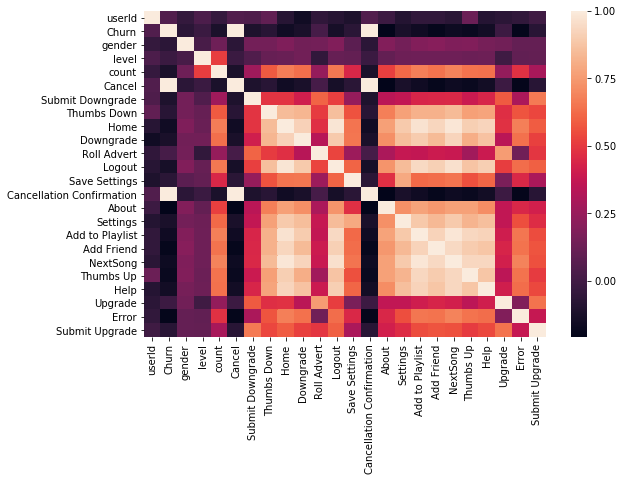

In [69]:
plt.figure(figsize=(9,6))
sns.heatmap(dfs.corr());

In [84]:
dfs.Churn.value_counts()

0    278
1     82
Name: Churn, dtype: int64

In [168]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 24 columns):
userId                       360 non-null int32
Churn                        360 non-null int32
gender                       360 non-null int32
level                        360 non-null int32
count                        360 non-null int64
Cancel                       360 non-null int64
Submit Downgrade             360 non-null int64
Thumbs Down                  360 non-null int64
Home                         360 non-null int64
Downgrade                    360 non-null int64
Roll Advert                  360 non-null int64
Logout                       360 non-null int64
Save Settings                360 non-null int64
Cancellation Confirmation    360 non-null int64
About                        360 non-null int64
Settings                     360 non-null int64
Add to Playlist              360 non-null int64
Add Friend                   360 non-null int64
NextSong                     36

In [108]:
X = dfs.drop(columns=['userId','Churn', 'Cancel', 'Cancellation Confirmation', 'count'],axis=1)
y = dfs['Churn']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=33)

In [109]:
X.head(3)

,gender,level,Submit Downgrade,Thumbs Down,Home,Downgrade,Roll Advert,Logout,Save Settings,About,Settings,Add to Playlist,Add Friend,NextSong,Thumbs Up,Help,Upgrade,Error,Submit Upgrade
0,1,1,0,52,71,24,4,22,2,9,10,45,27,1669,68,4,1,3,1
1,0,0,0,4,31,3,43,10,1,2,5,17,13,640,35,7,3,0,1
2,1,0,0,15,53,13,39,13,3,2,7,31,28,1131,39,9,4,2,1


## Logistic Regression Model

In [149]:
#logistics Regression Model
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))
print("Accuracy :",accuracy_score(y_test, predictions))
print("F1 Score :",f1_score(y_test, predictions))
print("Area Under the Curve",roc_auc_score(y_test, predictions))

             precision    recall  f1-score   support

          0       0.81      0.93      0.87        87
          1       0.25      0.10      0.14        21

avg / total       0.70      0.77      0.72       108

[[81  6]
 [19  2]]
Accuracy : 0.768518518519
F1 Score : 0.137931034483
Area Under the Curve 0.513136288998


## Decision Tree Classification Model

In [150]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, recall_score, f1_score

dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)
predictions = dtree.predict(X_test)

print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))
print("Accuracy :",accuracy_score(y_test, predictions))
print("F1 Score :",f1_score(y_test, predictions))
print("Area Under the Curve",roc_auc_score(y_test, predictions))


             precision    recall  f1-score   support

          0       0.94      0.89      0.91        87
          1       0.62      0.76      0.68        21

avg / total       0.88      0.86      0.87       108

[[77 10]
 [ 5 16]]
Accuracy : 0.861111111111
F1 Score : 0.68085106383
Area Under the Curve 0.823481116585


## Random Forest Classification Model

In [154]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix

rfc = RandomForestClassifier(n_estimators=300)
rfc.fit(X_train,y_train)
predictions = rfc.predict(X_test)

print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))
print("Accuracy :",accuracy_score(y_test, predictions))
print("F1 Score :",f1_score(y_test, predictions))
print("Area Under the Curve",roc_auc_score(y_test, predictions))

             precision    recall  f1-score   support

          0       0.96      1.00      0.98        87
          1       1.00      0.81      0.89        21

avg / total       0.96      0.96      0.96       108

[[87  0]
 [ 4 17]]
Accuracy : 0.962962962963
F1 Score : 0.894736842105
Area Under the Curve 0.904761904762


**Based on all above ML Models, Random Forest performs better than others.**

## Modelling on PySpark

In [128]:
# dropping columns "cancel", "Cancellation Confirmation", "count".
columns_to_drop = ["cancel", "Cancellation Confirmation", "count"] 
df_sparkify = df_sparkify.drop(*columns_to_drop)

In [132]:
df_sparkify.columns[2:]

['gender',
 'level',
 'Submit Downgrade',
 'Thumbs Down',
 'Home',
 'Downgrade',
 'Roll Advert',
 'Logout',
 'Save Settings',
 'About',
 'Settings',
 'Add to Playlist',
 'Add Friend',
 'NextSong',
 'Thumbs Up',
 'Help',
 'Upgrade',
 'Error',
 'Submit Upgrade']

In [169]:
df_sparkify.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- Churn: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- Submit Downgrade: long (nullable = true)
 |-- Thumbs Down: long (nullable = true)
 |-- Home: long (nullable = true)
 |-- Downgrade: long (nullable = true)
 |-- Roll Advert: long (nullable = true)
 |-- Logout: long (nullable = true)
 |-- Save Settings: long (nullable = true)
 |-- About: long (nullable = true)
 |-- Settings: long (nullable = true)
 |-- Add to Playlist: long (nullable = true)
 |-- Add Friend: long (nullable = true)
 |-- NextSong: long (nullable = true)
 |-- Thumbs Up: long (nullable = true)
 |-- Help: long (nullable = true)
 |-- Upgrade: long (nullable = true)
 |-- Error: long (nullable = true)
 |-- Submit Upgrade: long (nullable = true)



#### Machine Learning Code Starts:

In [201]:
assembler = VectorAssembler(inputCols=df_sparkify.columns[2:],outputCol="features")

In [203]:
output = assembler.transform(df_sparkify)
final_data = output.select('features', 'Churn')

In [204]:
train_data,test_data = final_data.randomSplit([0.7,0.3])

In [205]:
from pyspark.ml.classification import DecisionTreeClassifier,GBTClassifier,RandomForestClassifier
from pyspark.ml import Pipeline

In [263]:
# Using three classifiers before finalizing best performer

#dtc = DecisionTreeClassifier(labelCol='Churn',featuresCol='features')
rfc = RandomForestClassifier(labelCol='Churn',featuresCol='features', numTrees=300)
#gbt = GBTClassifier(labelCol='Churn',featuresCol='features')

In [264]:
# Train the models - Will run for some time
#dtc_model = dtc.fit(train_data)
rfc_model = rfc.fit(train_data)
#gbt_model = gbt.fit(train_data)

#### Model Comparison

Let's compare each of these models!

In [265]:
#dtc_predictions = dtc_model.transform(test_data)
rfc_predictions = rfc_model.transform(test_data)
#gbt_predictions = gbt_model.transform(test_data)

##### Evaluation Metrics:

In [210]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [211]:
# calculating accuracy
acc_evaluator = MulticlassClassificationEvaluator(labelCol="Churn", 
                                                  predictionCol="prediction", 
                                                  metricName="accuracy")
# calculating f1 score
f1_evaluator = MulticlassClassificationEvaluator(labelCol="Churn", 
                                                  predictionCol="prediction", 
                                                  metricName="f1")


In [266]:
#dtc_acc = acc_evaluator.evaluate(dtc_predictions)
rfc_acc = acc_evaluator.evaluate(rfc_predictions)
#gbt_acc = acc_evaluator.evaluate(gbt_predictions)

In [267]:
#dtc_f1 = f1_evaluator.evaluate(dtc_predictions)
rfc_f1 = f1_evaluator.evaluate(rfc_predictions)
#gbt_f1 = f1_evaluator.evaluate(gbt_predictions)

In [271]:
print("Here are the results!")
print('-'*80)
print('A single decision tree had an accuracy of: {0:2.2f}%'.format(dtc_acc*100))
print('-'*80)
print('A random forest ensemble had an accuracy of: {0:2.2f}%'.format(rfc_acc*100))
print('-'*80)
print('A ensemble using GBT had an accuracy of: {0:2.2f}%'.format(gbt_acc*100))

Here are the results!
--------------------------------------------------------------------------------
A single decision tree had an accuracy of: 80.00%
--------------------------------------------------------------------------------
A random forest ensemble had an accuracy of: 80.00%
--------------------------------------------------------------------------------
A ensemble using GBT had an accuracy of: 85.00%


In [272]:
print("Here are the results!")
print('-'*80)
print('A single decision tree had F1 Score of: {0:2.2f}%'.format(dtc_f1*100))
print('-'*80)
print('A random forest ensemble had F1 Score of: {0:2.2f}%'.format(rfc_f1*100))
print('-'*80)
print('A ensemble using GBT had F1 Score of: {0:2.2f}%'.format(gbt_f1*100))

Here are the results!
--------------------------------------------------------------------------------
A single decision tree had F1 Score of: 76.96%
--------------------------------------------------------------------------------
A random forest ensemble had F1 Score of: 72.80%
--------------------------------------------------------------------------------
A ensemble using GBT had F1 Score of: 85.12%


In [218]:
binary_evaluator = BinaryClassificationEvaluator(labelCol='Churn')
binary_evaluator2 = BinaryClassificationEvaluator(labelCol='Churn', metricName='areaUnderPR')


In [268]:
#dtc_auc = binary_evaluator.evaluate(dtc_predictions)
rfc_auc = binary_evaluator.evaluate(rfc_predictions)
#gbt_auc = binary_evaluator.evaluate(gbt_predictions)

In [273]:
print("Here are the results!")
print('-'*80)
print('A single decision tree had Area Under the Curve Score of: {0:2.2f}%'.format(dtc_auc*100))
print('-'*80)
print('A random forest ensemble had Area Under the Curve Score of: {0:2.2f}%'.format(rfc_auc*100))
print('-'*80)
print('A ensemble using GBT had Area Under the Curve Score of: {0:2.2f}%'.format(gbt_auc*100))

Here are the results!
--------------------------------------------------------------------------------
A single decision tree had Area Under the Curve Score of: 54.31%
--------------------------------------------------------------------------------
A random forest ensemble had Area Under the Curve Score of: 81.64%
--------------------------------------------------------------------------------
A ensemble using GBT had Area Under the Curve Score of: 80.48%


In [269]:
#dtc_aupr = binary_evaluator2.evaluate(dtc_predictions)
rfc_aupr = binary_evaluator2.evaluate(rfc_predictions)
#gbt_aupr = binary_evaluator2.evaluate(gbt_predictions)

In [274]:
print("Here are the results!")
print('-'*80)
print('A single decision tree had Area Under Precision-Recall Curve: {0:2.2f}%'.format(dtc_aupr*100))
print('-'*80)
print('A random forest ensemble had Area Under Precision-Recall Curve: {0:2.2f}%'.format(rfc_aupr*100))
print('-'*80)
print('A ensemble using GBT had Area Under Precision-Recall Curve: {0:2.2f}%'.format(gbt_aupr*100))

Here are the results!
--------------------------------------------------------------------------------
A single decision tree had Area Under Precision-Recall Curve: 22.52%
--------------------------------------------------------------------------------
A random forest ensemble had Area Under Precision-Recall Curve: 59.89%
--------------------------------------------------------------------------------
A ensemble using GBT had Area Under Precision-Recall Curve: 50.63%


In [248]:
# Confusion Matrix for Gradient Boosting Algo
df_gbt = gbt_predictions.select(['Churn', 'prediction']).toPandas()
print(classification_report(df_gbt['Churn'], df_gbt['prediction']))
confusion_matrix(df_gbt['Churn'], df_gbt['prediction'])

             precision    recall  f1-score   support

          0       0.91      0.90      0.90        78
          1       0.65      0.68      0.67        22

avg / total       0.85      0.85      0.85       100



array([[70,  8],
       [ 7, 15]])

In [249]:
df_gbt.groupby('Churn').count()

,prediction
Churn,
0,78
1,22


In [261]:
# Confusion Matrix for Random Forest
df_rfc = rfc_predictions.select(['Churn', 'prediction']).toPandas()
print(classification_report(df_rfc['Churn'], df_rfc['prediction']))
confusion_matrix(df_rfc['Churn'], df_rfc['prediction'])

             precision    recall  f1-score   support

          0       0.80      1.00      0.89        78
          1       1.00      0.09      0.17        22

avg / total       0.84      0.80      0.73       100



array([[78,  0],
       [20,  2]])

**Based on above results Gradient Boosting Algorithm performs better to predict Churn Class users profiles.**

In [159]:
rfc_fit.featureImportances

SparseVector(19, {0: 0.009, 1: 0.0031, 2: 0.0036, 3: 0.0838, 4: 0.048, 5: 0.0615, 6: 0.0635, 7: 0.0545, 8: 0.0147, 9: 0.081, 10: 0.0854, 11: 0.0733, 12: 0.152, 13: 0.046, 14: 0.0788, 15: 0.0246, 16: 0.0588, 17: 0.0327, 18: 0.0258})

### Preliminary Analysis and Test Run Completed here. I will combine the above steps and run them on AWS Spark Cluster.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.